## Notebook Structure

This notebook is organized as follows:
```{mermaid}
flowchart TD
    A[1. Imports and Config] --> B[2. Load Raw Data]
    B --> C[3. Dataset Structure]
    C --> D[4. Basic Statistics]
    D --> E[5. Missing Values]
    E --> F[6. Duplicate Rows]
    F --> G[7. Unique Values]
    G --> H[8. Summary of Findings]

    style A fill:#1e3a5f,color:#fff
    style B fill:#1e3a5f,color:#fff
    style C fill:#1e3a5f,color:#fff
    style D fill:#1e3a5f,color:#fff
    style E fill:#1e3a5f,color:#fff
    style F fill:#1e3a5f,color:#fff
    style G fill:#1e3a5f,color:#fff
    style H fill:#2d6a4f,color:#fff
```

> **Goal:** Understand the raw dataset before touching it.
> Only observation here — no cleaning, no transformation.

### Quick Navigation

| Section | Description |
|---|---|
| [1. Imports & Config](#1.-Imports-&-Config) | Load libraries and project configuration |
| [2. Load Raw Data](#2.-Load-Raw-Data) | Read CSV into pandas DataFrame |
| [3. Dataset Structure](#3.-Dataset-Structure) | Inspect columns, types and shape |
| [4. Basic Statistics](#4.-Basic-Statistics) | Statistical summary of all variables |
| [5. Missing Values](#5.-Missing-Values) | Count, percentage and visualization |
| [6. Duplicate Rows](#6.-Duplicate-Rows) | Check for exact duplicates |
| [7. Unique Values](#7.-Unique-Values) | Cardinality analysis per column |
| [8. Summary of Findings](#8.-Summary-of-Findings) | All findings and cleaning agenda |

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pathlib import Path
from loguru import logger
import yaml

# Plot settings
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 5)

## 1. Imports & Config 

In [25]:
with open("../configs/config.yaml", "r") as f:
    config = yaml.safe_load(f) # Reads the YAML file and converts to python dictionary

# Paths
raw_path = Path("../") / config["paths"]["raw_data"]
logger.info(f"Raw data path: {raw_path}")

# `Path("../")` — creates a Path object pointing one folder up (to `powersight/`)
# `config["paths"]["raw_data"]` — gets the value `"data/raw/household_power_consumption.txt"` from your config
#`/` — this is not division here. When used with `Path` objects, `/` joins paths together. So the result is:
# ../data/raw/household_power_consumption.txt

2026-02-24 09:21:57.108 | INFO     | __main__:<module>:6 - Raw data path: ../data/raw/household_power_consumption.txt


## 2. Load Raw Data

In [26]:
df = pd.read_csv(raw_path, sep = ";", na_values=["?"], low_memory=False)
# The actual missing values in this dataset are marked with a "?" character 
# that's how UCI encoded them. So we tell pandas to treat "?" as NaN instead.
logger.info(f"Dataset loaded succesfully")
logger.info(f"Shape: {df.shape[0]:,} rows× {df.shape[1]} columns")

2026-02-24 09:21:57.930 | INFO     | __main__:<module>:4 - Dataset loaded succesfully
2026-02-24 09:21:57.931 | INFO     | __main__:<module>:5 - Shape: 2,075,259 rows× 9 columns


## 3. Dataset structure
Understanding the structure of the dataset is the first step in any data project.
We inspect:
- **Column names** — what variables are available
- **Data types** — whether pandas inferred the correct types

Incorrect data types are one of the most common sources of bugs in data pipelines.
For example, a numeric column loaded as `object` will break any statistical computation.

In [27]:
# Dataset structure: column names, data types, non-null counts and memory usage
logger.info("Dataset info:")
df.info()

2026-02-24 09:21:57.935 | INFO     | __main__:<module>:2 - Dataset info:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


- `Date` and `Time` are loaded as `object` (string) — they must be combined 
  into a single `datetime` column during cleaning
- All 7 measurement columns are correctly inferred as `float64`
- Memory usage is ~142.5 MB — manageable in memory for this project

### First and last rows

We inspect the first and last rows of the dataset to:
- Confirm the data loaded correctly
- Understand the format of each column
- Spot any obvious issues at the edges of the dataset


In [28]:
# First 5 rows
df.head()

# # Last 5 rows
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


- Data starts on **16/12/2006** and the last rows show **26/11/2010**
- Date format is `DD/MM/YYYY` and Time is `HH:MM:SS` — both need to be 
  combined into a single datetime column during cleaning
- Values look realistic for household energy consumption
- No obvious formatting issues at the edges of the dataset

## 4. Basic statistics

We use `describe()` to get a statistical summary of all numeric columns.
This gives us a first look at the range, central tendency, and spread of each variable.
It also reveals potential outliers — if the max value is far from the 75th percentile, that's a red flag worth investigating.

In [29]:
# Statistical summary of all numeric columns
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


- **Missing values confirmed** — count shows 2,049,280 vs 2,075,259 total rows.
  Approximately 25,979 missing values exist across numeric columns
- **Global_active_power** — max of 11.12 kW vs 75th percentile of 1.528 kW 
  suggests consumption spikes from high-power appliances
- **Global_reactive_power** — low values (mean 0.12 kVAR) indicate the household 
  mostly uses resistive loads. Reactive power is non-working power caused by 
  inductive loads like motors and transformers
- **Voltage** — mean 240.8V with std of only 3.24V confirms a stable European 
  power supply (230V nominal). No concerning fluctuations
- **Global_intensity** — current in Amperes. Max of 48.4A is near the household 
  circuit breaker limit, confirming occasional peak demand events
- **Sub_metering columns** — zero-inflated distributions, appliances are 
  inactive most of the time. Kitchen (Sub_metering_1) and laundry 
  (Sub_metering_2) show occasional high usage spikes

## 5. Missing values
Missing data is one of the most common data quality issues in real-world datasets.
We need to understand:
- **How many** values are missing per column
- **What percentage** of each column is missing
- **Whether the missing pattern** is random or systematic


In [30]:
# count and percentage of missing values per column
missing_count = df.isnull().sum()
missing_pct   = (missing_count / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    "missing_count" : missing_count,
    "missing_pct" : missing_pct
})

logger.info(f"Total missing values: {missing_count.sum()}")
logger.info(f"Columns with missing values: {missing_count[missing_count > 0].count()}")

# Show only columns that have missing values
missing_df[missing_df["missing_count"] > 0]

2026-02-24 09:21:58.389 | INFO     | __main__:<module>:10 - Total missing values: 181853


2026-02-24 09:21:58.390 | INFO     | __main__:<module>:11 - Columns with missing values: 7


,missing_count,missing_pct
Global_active_power,25979,1.25
Global_reactive_power,25979,1.25
Voltage,25979,1.25
Global_intensity,25979,1.25
Sub_metering_1,25979,1.25
Sub_metering_2,25979,1.25
Sub_metering_3,25979,1.25


- **25,979 missing values** across all 7 numeric columns — exactly the same 
  count in every column
- This is not random — it suggests the meter went offline for entire minutes, 
  recording nothing across all channels simultaneously
- This is classified as **MNAR (Missing Not At Random)** — the missingness 
  has a physical cause
- **Cleaning strategy:** these rows will be dropped entirely in the next 
  notebook since they represent meter outages, not missing individual readings
- Missing percentage is only **1.25%** — low enough that dropping these rows 
  will not significantly affect our analysis

### Missing values visualization

We use `missingno` to visually confirm the missing pattern across all columns.
A matrix plot shows which rows are missing and whether the pattern is correlated.

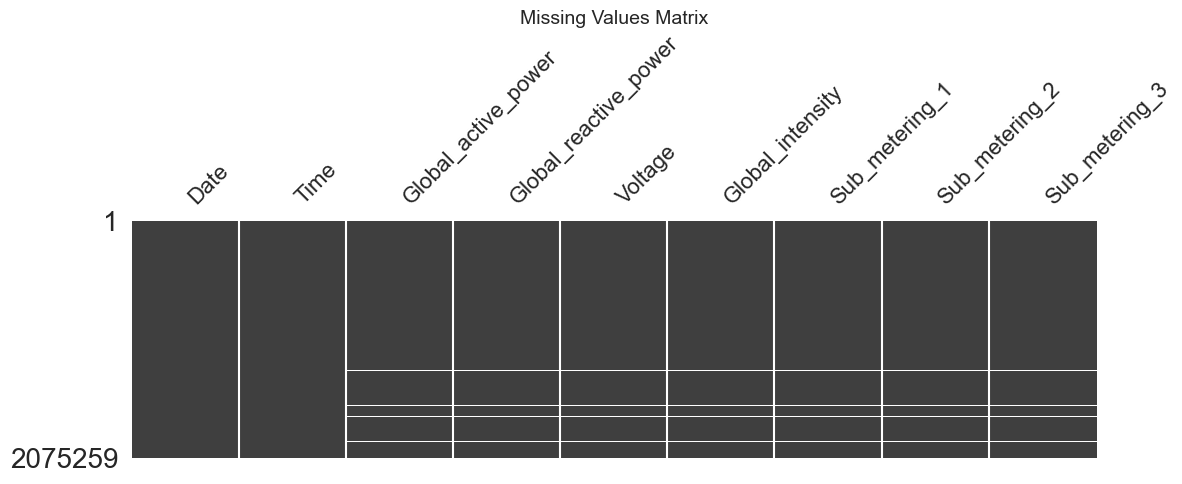

In [31]:
import missingno as msno


fig, ax = plt.subplots(figsize=(12, 5))
msno.matrix(df, ax=ax, sparkline=False)
ax.set_title("Missing Values Matrix", fontsize=14)
plt.tight_layout()
plt.savefig("../reports/figures/missing_values_matrix.png", dpi=150)
plt.show()

The missingno matrix visually confirms our earlier numerical finding.

**How to read this plot:**
- **Dark areas** = data is present
- **White horizontal lines** = missing values

**What we observe:**
- `Date` and `Time` columns are completely dark — no missing values
- All 7 numeric columns show white lines appearing at the **exact same rows** 
  simultaneously — every column drops together at the same moments
- The missing lines are clustered near the bottom of the dataset

**What this tells us:**
This is the visual signature of a **systemic meter outage** — not random missing data. When the meter went offline, it stopped recording all channels at once. If missingness were random (MCAR), the white lines would appear scattered randomly across different rows in different columns like noise.

This visually confirms our MNAR classification and validates our cleaning strategy of dropping these rows entirely.

## 6. Duplicate Rows

We check for exact duplicate rows — same timestamp and same values across all columns. Duplicates can distort statistics and model training by giving certain time periods more weight than they deserve.

In [32]:
duplicate_count = df.duplicated().sum()
logger.info(f"Duplicate rows: {duplicate_count:,}")

2026-02-24 09:22:00.835 | INFO     | __main__:<module>:2 - Duplicate rows: 0


- **0 duplicate rows** found across 2,075,259 records
- No duplicate timestamps exist in the dataset
- No action required in the cleaning step for duplicates

## 7. Unique values

We check the number of unique values per column to understand cardinality.
This helps identify:
- Columns that behave like categories (low unique count)
- Columns that are truly continuous (high unique count)
- Potential ID columns that should be dropped

In [33]:
unique_counts = df.nunique()
logger.info("Unique values per column:")
print(unique_counts)

2026-02-24 09:22:01.043 | INFO     | __main__:<module>:2 - Unique values per column:


Date                     1442
Time                     1440
Global_active_power      4186
Global_reactive_power     532
Voltage                  2837
Global_intensity          221
Sub_metering_1             88
Sub_metering_2             81
Sub_metering_3             32
dtype: int64


- **Date** — 1,442 unique days (~4 years of data, Dec 2006 to Nov 2010)
- **Time** — exactly 1,440 unique values = one reading per minute per day.
  Confirms the dataset sampling frequency is **1 minute**
- **Global_active_power** — 4,186 unique values, truly continuous measurement
- **Global_reactive_power** — only 532 unique values, less variable than active power
- **Global_intensity** — 221 unique values, current drawn in fixed steps
- **Sub_metering_3** — only 32 unique values, electric water heater and AC 
  operate at fixed power levels (on/off behavior)
- **Sub_metering_1 and 2** — 88 and 81 unique values respectively, 
  kitchen and laundry appliances with discrete power states

## 8. Summary of Findings

This notebook performed a complete **data quality audit** of the raw UCI 
Household Electric Power Consumption dataset. Here is a summary of all findings:

### Dataset Overview
- **2,075,259 rows × 9 columns**
- **4 years of data** — December 2006 to November 2010
- **1 reading per minute** — confirmed by 1,440 unique time values
- **Memory usage** — 142.5 MB, manageable in memory

### Data Types
- `Date` and `Time` loaded as `object` — must be combined into a single 
  `datetime` column during cleaning
- All 7 measurement columns correctly inferred as `float64`

### Missing Values
- **25,979 missing values (1.25%)** — same count across all 7 numeric columns
- Classified as **MNAR** — meter outages caused all channels to drop simultaneously
- **Strategy:** drop these rows entirely

### Duplicates
- **0 duplicate rows** — no action required

### Statistical Observations
- `Global_active_power` — consumption spikes up to 11.12 kW vs mean of 1.09 kW
- `Voltage` — stable European supply, mean 240.8V with std of only 3.24V
- `Global_intensity` — max 48.4A, occasionally near circuit breaker limit
- `Sub_metering` columns — zero-inflated, appliances inactive most of the time

### Agenda for Next Notebook
The following actions will be performed in `02_data_cleaning.ipynb`:

1. Combine `Date` and `Time` into a single `datetime` column
2. Drop all 25,979 rows with missing values
3. Detect and handle outliers
4. Extract time features: hour, day of week, month, year, is_weekend
5. Engineer anomaly labels for classification
6. Save cleaned dataset to `data/processed/energy_clean.parquet`